# Загрузка Pandas и очистка данных

In [25]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt 

In [52]:
# File to build model
df = pd.read_csv('../input/datasets1/main_task.csv')

# File to predict on real dataset
# df = pd.read_csv('../input/datasets1/kaggle_task.csv')

In [27]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

In [53]:
# Functions to preprocess data
def fillnaWithMode(name):
    df[name].fillna(df[name].mode()[0], inplace=True)
    
def fillnaWithMedian(name):
    df[name].fillna(df[name].median(), inplace=True)
    
def fillnaWithNewValue(name, value):
    df[name].fillna(value, inplace=True)
    
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [54]:
# Look at the total statistics of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   Name               10000 non-null  object 
 2   City               10000 non-null  object 
 3   Cuisine Style      7693 non-null   object 
 4   Ranking            10000 non-null  float64
 5   Price Range        6525 non-null   object 
 6   Number of Reviews  9343 non-null   float64
 7   Reviews            9998 non-null   object 
 8   URL_TA             10000 non-null  object 
 9   ID_TA              10000 non-null  object 
dtypes: float64(2), object(8)
memory usage: 781.4+ KB


In [55]:
df.groupby('Price Range')['Price Range'].value_counts()

Price Range  Price Range
$            $              1537
$$ - $$$     $$ - $$$       4629
$$$$         $$$$            359
Name: Price Range, dtype: int64

(array([830.,  19.,   8.,   3.,   4.,   1.,   1.,   0.,   1.,   1.]),
 array([  1. ,  49.6,  98.2, 146.8, 195.4, 244. , 292.6, 341.2, 389.8,
        438.4, 487. ]),
 <BarContainer object of 10 artists>)

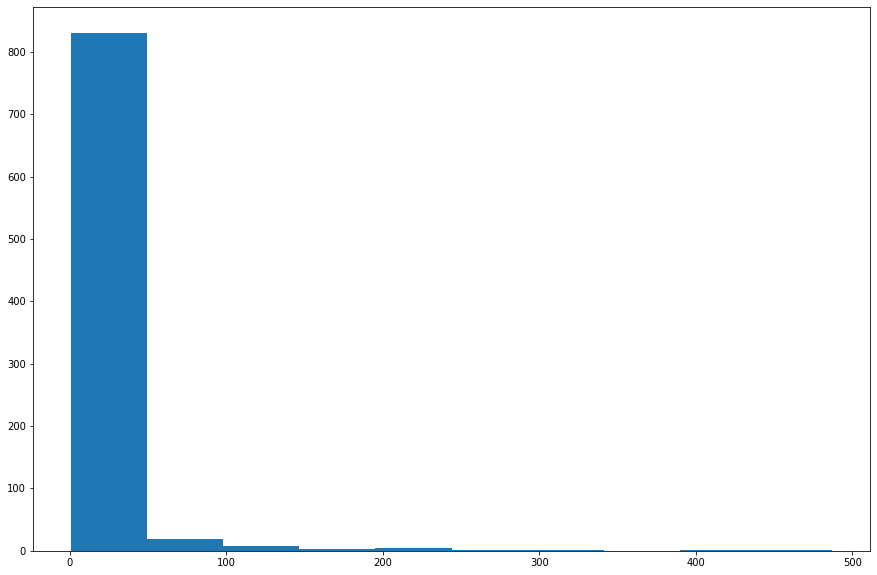

In [56]:
# On diagram we can see uneven distribution in column Number of Reviews
plt.rcParams['figure.figsize'] = (15, 10)
plt.hist(df.groupby('Number of Reviews')['Number of Reviews'].value_counts())

In [57]:
# Let's fill less than 10% missing values in numerical column with median value
fillnaWithMedian('Number of Reviews')

In [58]:
# There are too much missing values in Price Range column to fill it with mean or median. But it seems high relative to Rating, so fill it with 'Undef' value
fillnaWithNewValue('Price Range', 'Undef')

In [59]:
# Fill missing values in Cuisine Style with a most popular cuisine in the City
for city in df.groupby('City')['City'].nunique().index:
    popular = df[df['City'] == city].groupby('City')['Cuisine Style'].value_counts().nlargest(1).index[0][1][1:-1].split(',')[0]
    df['Cuisine Style'] = np.where((df['City'] == city) & (df['Cuisine Style'].isnull()), '[' + popular + ']', df['Cuisine Style'])

In [60]:
# Let's find popular special cuisines
df.groupby('Cuisine Style')['Cuisine Style'].value_counts().nlargest(25)


Cuisine Style                 Cuisine Style               
['Italian']                   ['Italian']                     773
['French']                    ['French']                      585
['Spanish']                   ['Spanish']                     523
['European']                  ['European']                    437
['Bar']                       ['Bar']                         270
['Greek']                     ['Greek']                       187
['Cafe']                      ['Cafe']                        125
['Chinese']                   ['Chinese']                     111
['French', 'European']        ['French', 'European']           98
['Austrian']                  ['Austrian']                     86
['Pizza']                     ['Pizza']                        83
['Polish']                    ['Polish']                       80
['Italian', 'Pizza']          ['Italian', 'Pizza']             79
['European', 'Portuguese']    ['European', 'Portuguese']       73
['Vegetarian Frie

<AxesSubplot:>

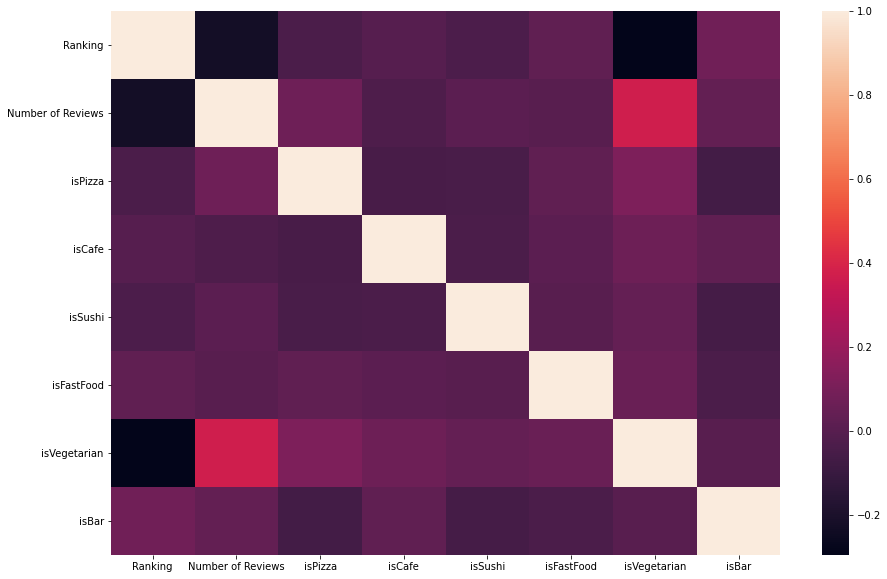

In [61]:
# Now will make some columns for most interesting cuisines
df2 = df.copy()
df2['isPizza'] = np.where(df2['Cuisine Style'].str.contains("Pizza"), 1, 0)
df2['isCafe'] = np.where(df2['Cuisine Style'].str.contains("Cafe"), 1, 0)
df2['isSushi'] = np.where(df2['Cuisine Style'].str.contains("Sushi"), 1, 0)
df2['isFastFood'] = np.where(df2['Cuisine Style'].str.contains("Fast Food"), 1, 0)
df2['isVegetarian'] = np.where(df2['Cuisine Style'].str.contains("Vegetarian"), 1, 0)
df2['isBar'] = np.where(df2['Cuisine Style'].str.contains("Bar"), 1, 0)

df2 = df2.drop(['Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA'], axis = 1)
# And look at correlation with Rating
df2.corr()
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(df2.corr())

In [62]:
# isVegetarian is the only interesting correlation. So keep it in original dataframe
df['isVegetarian'] = np.where(df['Cuisine Style'].str.contains("Vegetarian"), 1, 0)

In [63]:
# Now make duumies from City and PriceRange
df = pd.get_dummies(df, columns = ['City','Price Range'])

In [64]:
# Check reviews with words 'good' and 'nice'
df['hasGoodReview'] = np.where((df['Reviews'].str.contains("good") | df['Reviews'].str.contains("Good") | df['Reviews'].str.contains("Nice")| df['Reviews'].str.contains("nice")), 1, 0)

In [50]:
# Does not get any tripadvisor site. Pity

# r = requests.get('https://www.tripadvisor.com/Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html')
# r = requests.get('https://www.tripadvisor.com/Restaurant_Review-g189180-d12503536-Reviews-Dick_s_Bar-Porto_Porto_District_Northern_Portugal.html')
# r.status_code

KeyboardInterrupt: 

<AxesSubplot:>

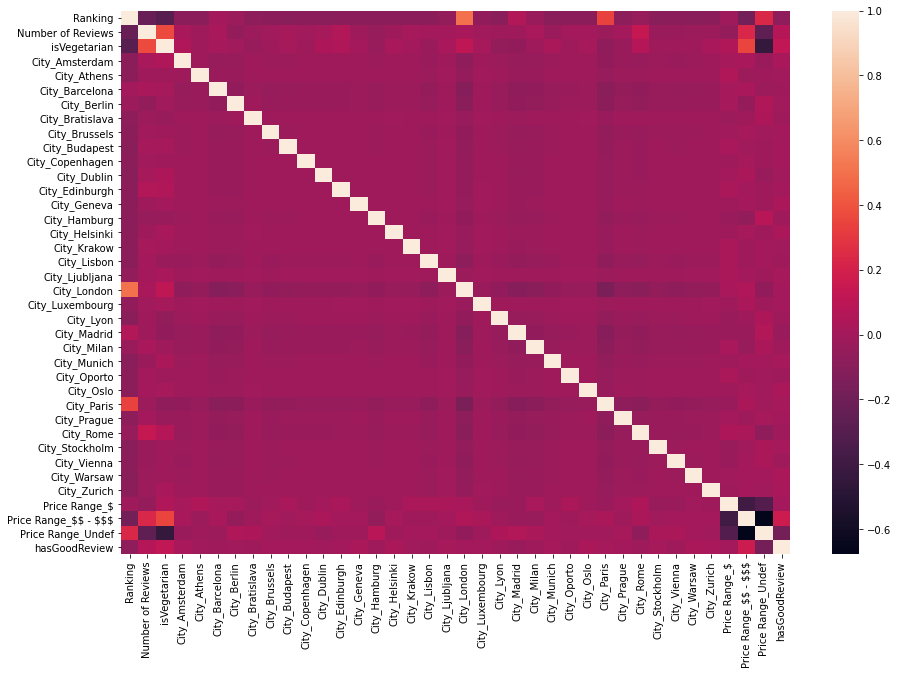

In [65]:
# Let's look at the correlation matrix 
plt.rcParams['figure.figsize'] = (15, 10)
dfcorr = df.copy()
dfcorr = dfcorr.drop(['Price Range_$$$$'], axis=1)
sns.heatmap(dfcorr.corr())

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [66]:
df = df.drop(['Cuisine Style', 'Reviews', 'URL_TA', 'ID_TA'], axis = 1)


In [67]:
df.head()

,Restaurant_id,Name,Ranking,Number of Reviews,isVegetarian,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,Price Range_$,Price Range_$$ - $$$,Price Range_$$$$,Price Range_Undef,hasGoodReview
0,id_0,Le Perchoir,12963.0,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,id_1,Ravintola Kolmon3n,106.0,97.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,id_2,Black Ivy,810.0,28.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,id_3,Quirinale,1669.0,202.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,id_4,Massimo Ristorante,37.0,162.0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1


In [43]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
y = df['Rating']

In [44]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [45]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [46]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [92]:
# Block to make prediction on real data
# X = df.drop(['Restaurant_id', 'Name'], axis = 1)
# y = regr.predict(X)
# Round up to 0.5
# y = list(map(lambda a : round(0.5 * round(float(a)/0.5), 1), y))
# np.savetxt(
#     'submission.csv',
#     np.rec.fromarrays([df['Restaurant_id'], y]),
#     fmt=['%s', '%f'],
#     delimiter=',',
#     header='Restaurant_id,Rating',
#     comments='',
# )


<AxesSubplot:>

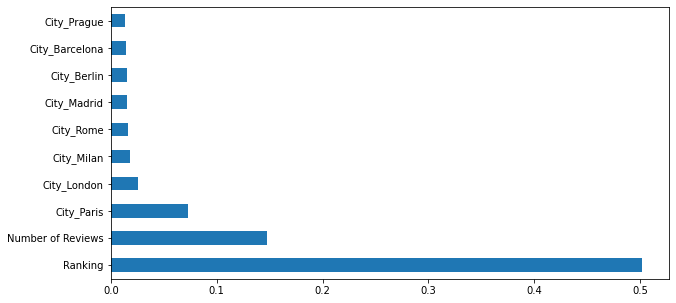

In [49]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)
# submission['Rating'] = y_pred
plt.rcParams['figure.figsize'] = (10, 5)
important_features = pd.Series(regr.feature_importances_, index=X.columns)
important_features.nlargest(10).plot(kind="barh")

In [51]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2169565
